# Application NutriScore

## Le pipeline de la donnée

In [1]:
import os
import wget
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

### La lecture du csv

In [2]:
csv_path = "./en.openfoodfacts.org.products.csv"
csv_url = "https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv"
nb_lines = 1000000
if not os.path.exists(csv_path):
    print('downloading ', csv_url)
    wget.download(csv_url,csv_path)
    print('downloaded', csv_path)
print("Chargement du csv dans un DataFrame")
df_csv = pd.read_csv(csv_path,sep='\t', low_memory =False ,encoding='utf-8', nrows = nb_lines)
print("Nous avons gardé les "+ str(nb_lines)+" premières lignes du csv")
nb_colonne_csv = len(df_csv.columns)
print("Le DataFrame contient " + str(nb_colonne_csv) + " colonnes" )

Chargement du csv dans un DataFrame
Nous avons gardé les 1000000 premières lignes du csv
Le DataFrame contient 187 colonnes


### Suppression les colonnes inutiles

Nos choix:

    * Supprimer les colonnes vides
    * Travailler sur les données quantitatives
    * Uniquement les quantités pour 100g
    * On garde la variable cible

Filtrage à l'aide d'une regex

In [3]:
df_csv['nutriscore_grade'].value_counts()

d    144560
c     91048
e     81434
a     74616
b     55106
Name: nutriscore_grade, dtype: int64

In [4]:
# erase empty columns
nb_colonne = len(df_csv.columns)
df_csv.dropna(axis=1, how='all',inplace = True)
print("On a supprimé "+ str(nb_colonne - len(df_csv.columns)) + " colonnes vides")
df_100g = df_csv.filter(regex=("_100g"))
# parmi les variables autres que les variables quantitatives on garde seulement le nutriscore
df = df_csv[['nutriscore_grade','nutriscore_score']].join(df_100g)
print("On a supprimé "+ str(len(df_csv.columns) - len(df_100g.columns))+ " colonnes qualitatives")
print("Notre DataFrame n'a plus que " + str(len(df.columns)) + " colonnes") 


On a supprimé 41 colonnes vides
On a supprimé 69 colonnes qualitatives
Notre DataFrame n'a plus que 79 colonnes


### Suppression des lignes inutiles

Nos choix:

    * Supprimer les lignes vides
    * Supprimer les lignes qui n'ont pas de variables explicatives
    * Supprimer les doublons

Beaucoup de doublons, de nombreux produits avec des appellations différentes partagent des compositions identiques

In [5]:
nb_lignes = len(df)
df.dropna(axis = 0, how = 'all', inplace = True)
print(str(nb_lignes - len(df)), " lignes vides supprimées")
nb_lignes = len(df)
df.dropna(subset = ['nutriscore_grade', ], inplace = True)
print(str(nb_lignes - len(df)) +" enregistrements sans variable explicative")
print("Il reste " + str(len(df[df.duplicated(keep="first")])) + " doublons")
df.drop_duplicates(keep="last",inplace=True)
df_car =df_csv.loc[(df_csv['energy-kcal_100g'] == 418.0) & (df_csv['energy_100g'] == 1749.0) & (df_csv['fat_100g'] == 12.5) & (df_csv['saturated-fat_100g'] == 7.0)]


132471  lignes vides supprimées
420765 enregistrements sans variable explicative
Il reste 94011 doublons


### Enregistrements qui partagent les mêmes valeurs sur les variables explicatives

In [6]:
pd.DataFrame(df_car['product_name'])

,product_name
547954,Caramel breton au beurre sale
754470,Caramel au beurre salé
754471,Caramel au beurre salé au sel de guerande
831135,Boite sucettes caramel papillote
831141,Caramel au beurre salé au sel de Guérande
...,...
999983,Caramels tendres au beurre salé
999986,Caramel pain d’épice
999989,Caramel pain d'épices
999991,Caramel pain d’epices


### Suppression des colonnes restantes incomplètes

Nos choix:
    
    * supprimer les colonnes qui ont plus de 25% de valeurs manquantes

Le reste des colonnes seront complétées lors du preprocessing du pipeline du modèle

In [7]:
seuil_remplissage = 0.25
useful_col = [col for col in df.columns if df[col].isna().mean() < seuil_remplissage]

clean_df = df[useful_col]
print(str(len(df.columns)- len(clean_df.columns)) + " colonnes ont été supprimées")

66 colonnes ont été supprimées


### Traitement des valeurs aberrantes 



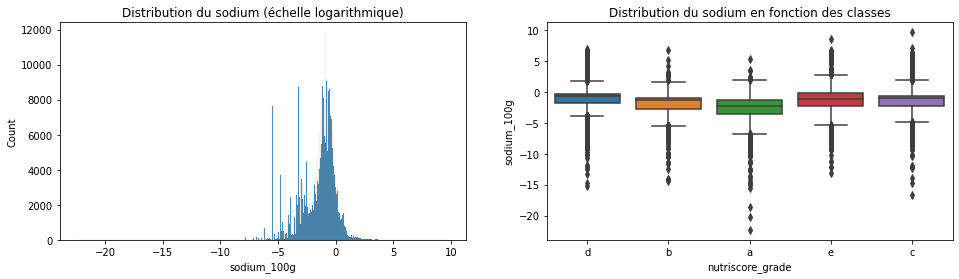

In [8]:
sod_gr_3 = clean_df[(clean_df['sodium_100g'] != 0.0)]

log_sod = np.log(sod_gr_3['sodium_100g'])
sod_all_gr = clean_df[clean_df['sodium_100g'] != 0.0]
fig, ax =plt.subplots(1,2)
fig.set_size_inches(16,4)
ax[0].title.set_text('Distribution du sodium (échelle logarithmique)')
ax[1].title.set_text('Distribution du sodium en fonction des classes')
hist_sod= sns.histplot(x=log_sod, ax=ax[0])


box_sod= sns.boxplot(x=clean_df['nutriscore_grade'], y=np.log(sod_all_gr['sodium_100g']), ax=ax[1])
plt.show()

L'analyse graphique des boxplots et des distributions: 

    * La présence de valeurs aberrantes
    * Certaines variables ne suivent pas une distribution gaussienne
    * Les boxplots ne donnent pas d'informations sur l'explicabilité d'une variable

Une mise à l'échelle logarithmique peut faciliter la visualisation des distributions
Le critère retenu se base sur l'IQR (InterQuartile Range), plus générale que le z-score

In [9]:
encod_df = clean_df.copy()
encoding = {
    'a':5,
    'b':4,  
    'c':3,
    'd':2,
    'e':1,
}

encod_df['nutriscore_grade'] = clean_df['nutriscore_grade'].map(encoding)

In [10]:
def outlier_treatment(datacolumn):
    Q1, Q3 = datacolumn.quantile([0.25,0.75])
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

In [11]:
nbre_lignes = len(encod_df)

for col in encod_df.columns:
    low, up = outlier_treatment(encod_df[col])
    index_list = encod_df[(encod_df[col] > up) | (encod_df[col] < low)].index
    clean_df = clean_df.drop(index_list)
    encod_df = encod_df.drop(index_list)
    # on copie dans un nouveau dataframe pour éviter de supprimer des valeurs à chaque fois
print(str(nbre_lignes - len(encod_df)) + " lignes avec des valeurs aberrantes supprimées")

126654 lignes avec des valeurs aberrantes supprimées


In [12]:
clean_df.describe()

,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
count,226099.000000,217854.000000,225961.000000,225963.000000,225944.000000,225905.000000,225953.000000,225964.000000,226058.000000,226058.000000,178472.000000,226099.000000
mean,7.882485,244.898262,1020.586513,10.733555,3.702497,28.517459,9.472068,8.115897,0.855777,0.342316,0.389124,7.882485
std,8.420734,153.251824,639.690361,10.603001,4.360263,25.738558,12.002416,6.401238,0.722264,0.288907,1.418303,8.420734
min,-15.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,-0.500000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,1.000000,110.000000,460.000000,1.790000,0.100000,5.420000,0.800000,3.330000,0.166667,0.066667,0.000000,1.000000
50%,7.000000,233.000000,967.000000,7.500000,2.000000,19.620000,3.570000,6.670000,0.770000,0.308000,0.000000,7.000000
75%,15.000000,367.000000,1527.000000,17.500000,5.900000,51.160000,14.400000,12.000000,1.315000,0.526000,0.000000,15.000000
max,36.000000,821.000000,3435.000000,51.610000,17.500000,100.000000,47.170000,26.300000,2.997500,1.199000,8.320000,36.000000


In [13]:
df_corr = encod_df.corr(method = 'pearson')
df_corr

,nutriscore_grade,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
nutriscore_grade,1.000000,-0.945694,-0.469062,-0.468681,-0.574357,-0.637139,-0.173927,-0.452791,0.064314,-0.381479,-0.381475,-0.005428,-0.945694
nutriscore_score,-0.945694,1.000000,0.569372,0.569924,0.657657,0.733035,0.241416,0.513179,-0.035161,0.405859,0.405862,-0.004788,1.000000
energy-kcal_100g,-0.469062,0.569372,1.000000,0.997222,0.720487,0.510638,0.703009,0.393622,0.210920,0.226857,0.226849,-0.035643,0.569372
energy_100g,-0.468681,0.569924,0.997222,1.000000,0.719355,0.510286,0.703504,0.394014,0.205900,0.224284,0.224284,-0.036991,0.569924
fat_100g,-0.574357,0.657657,0.720487,0.719355,1.000000,0.730540,0.130314,0.171877,0.201097,0.320919,0.320916,0.019644,0.657657
saturated-fat_100g,-0.637139,0.733035,0.510638,0.510286,0.730540,1.000000,0.066761,0.292478,0.147157,0.165983,0.165980,-0.017255,0.733035
carbohydrates_100g,-0.173927,0.241416,0.703009,0.703504,0.130314,0.066761,1.000000,0.529807,-0.131955,-0.049158,-0.049145,-0.058849,0.241416
sugars_100g,-0.452791,0.513179,0.393622,0.394014,0.171877,0.292478,0.529807,1.000000,-0.315899,-0.229545,-0.229547,0.022382,0.513179
proteins_100g,0.064314,-0.035161,0.210920,0.205900,0.201097,0.147157,-0.131955,-0.315899,1.000000,0.325936,0.325935,-0.057988,-0.035161
salt_100g,-0.381479,0.405859,0.226857,0.224284,0.320919,0.165983,-0.049158,-0.229545,0.325936,1.000000,0.999990,-0.006978,0.405859


### Analyser la pertinence des variables retenues

L'encodage de la variable cible permet de calculer ses corrélations:

    * avec les variables explicatives importantes
    * de supprimer les variables faiblement corrélées à la variable cible

Les corrélations permettent d'éliminer les variables explicatives qui fournissent les mêmes informations

    * on supprime les variables qui sont trop fortement corrélées entre elles



On a supprimé les colonnes:
    
    * fibres alimentaires, faiblement corrélées aux autres variables
    * sodium trop liée au sel et ne figure pas sur les produits alimentaires
    * nutriscores quantitatifs trop liés à la note nutriscore

In [14]:
nb_colonnes = len(encod_df.columns)
seuil_sign = 0.05
col_list = [col for col in encod_df.columns if np.abs(df_corr['nutriscore_grade'][col]) > seuil_sign]
###################################### on enlève l'encodage ###########################

clean_df = clean_df[col_list]
print("on a supprimé " + str(nb_colonnes - len(clean_df.columns)) + " colonnes")

on a supprimé 1 colonnes


In [15]:
# on ne peut pas supprimer uen colonne à la volée sur les dataframe il faut copier dans un autre df
clean_df = clean_df.drop(['nutriscore_score','nutrition-score-fr_100g','sodium_100g'], axis = 1)

## Préparation des données pour notre modèle

### Analyse de la répartition des modalités de la note nutriscore

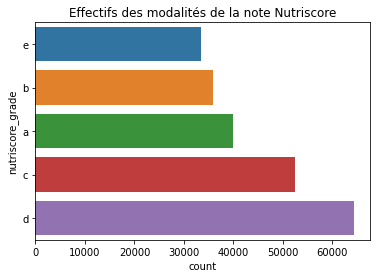

In [16]:
sns.countplot(y = clean_df['nutriscore_grade'],
              order = clean_df['nutriscore_grade'].value_counts(ascending=True).index).set_title('Effectifs des modalités de la note Nutriscore')
plt.show()

On choisit le down-sampling pour ne pas créer de nouvelles valeurs artificiellement:
    
    * on garde les enregistrements de la modalité la moins représentée
    * on choisit aléatoirement autant de valeurs pour les autres modalités

In [17]:
# taille de la classe moins représentée
min_size = min([len(clean_df[clean_df['nutriscore_grade'] == grade]) for grade in ['a','b','c','d','e']])

# équilibrage des classes
frames = [clean_df[clean_df['nutriscore_grade'] == grade].sample(min_size) for grade in ['a','b','c','d','e']]

# nouveau dataframe
down_samp = pd.concat(frames)
down_samp

,nutriscore_grade,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g
254006,a,250.0,1046.0,1.920000,0.0000,48.0800,5.7700,9.620000,1.0100
243802,a,94.0,393.0,4.120000,0.5900,3.5300,0.0000,10.590000,0.0300
90214,a,231.0,967.0,1.920000,0.0000,46.1500,3.8500,11.540000,0.9125
189613,a,280.0,1172.0,4.666700,0.6667,50.6667,2.6667,10.666700,0.8000
291675,a,250.0,1046.0,8.333333,0.0000,50.0000,0.0000,16.666667,0.0000
...,...,...,...,...,...,...,...,...,...
461429,e,469.0,1962.0,21.880000,6.2500,59.3800,37.5000,6.250000,0.7800
148147,e,357.0,1494.0,17.140000,11.4300,47.1400,34.2900,2.860000,0.8925
792410,e,309.0,1293.0,27.000000,11.0000,1.5000,1.5000,15.000000,2.1000
589363,e,482.0,2017.0,24.000000,12.3000,58.8000,28.7000,6.100000,1.1500


### Création des jeux de test et d'entraînement

On stratifie lors du split pour avoir une répartition équitables des modalités lors de l'entraîenement

In [18]:


# attention à ne pas intégrer la variable cible dans le train
down_samp_X = down_samp.drop('nutriscore_grade',axis=1)
down_samp_y = down_samp['nutriscore_grade']

X_train, X_test, y_train, y_test = train_test_split(
    down_samp_X, 
    down_samp_y, 
    test_size=0.3, 
    random_state=42,
    # on rajoute le stratify pour être sûr de la répartition équitable de chaque classe
    stratify=down_samp['nutriscore_grade'])



## Création du pipeline

### Le pre-processing du pipeline

In [19]:
# la stratégie est celle ce la médiane car on a pas réussi à déterminer si la distribution est normale
fill_strat = 'median'

Le pre-processing comprend, le remplissage des valeurs manquantes:
    
    * On remplit les valeurs manquantes avec le critère de la médiane, plus général que la moyenne

La mise à l'échelle des varibles explicatives:

    * On choisit le critère du Min-Max, plus général que le centrage et la réduction

### Le choix du modèle

On teste 3 modèles:

    * DecisionTreeClassifier
    * RandomForestClassifier
    * KNeighborsClassifier

On étudie l'effet d'un hyper-paramètre sur la qualité de l'entraînement:

    * La profondeur de(s) arbre(s) pour DecisionTree et RandomForest
    * Le nombre de voisins retenus pour KNeighbors
    
Les hyper-paramètres par défaut provoquent le sur-entraînement

In [20]:
# treeDecisionClassifier

max_steps = 20
param_range = range(2,max_steps+1)

prec_score_pred_DTC =[]
prec_score_train_DTC = []

for i in param_range:
    # création du pipeline
    nutri_pipe = Pipeline([

        ##################### fonctions de preprocessing du pipeline ##################
        ('filler', SimpleImputer(missing_values=np.nan, strategy=fill_strat)), 
        ('standardizer', StandardScaler()),

        ####################### spécification du modèle #################################

        ('dtc', DecisionTreeClassifier(max_depth= i, random_state=0))])
    
    nutri_pipe.fit(X_train,y_train)
    
    y_pred=nutri_pipe.predict(X_test)
    y_comp=nutri_pipe.predict(X_train)
    # RandomForestClassifier
    # pas de déséquilibre de classe donc on peut utiliser sans weighted
    prec_score_pred_DTC.append(metrics.f1_score(y_pred, y_test, average='macro'))
    prec_score_train_DTC.append(metrics.f1_score(y_comp, y_train,average='macro'))

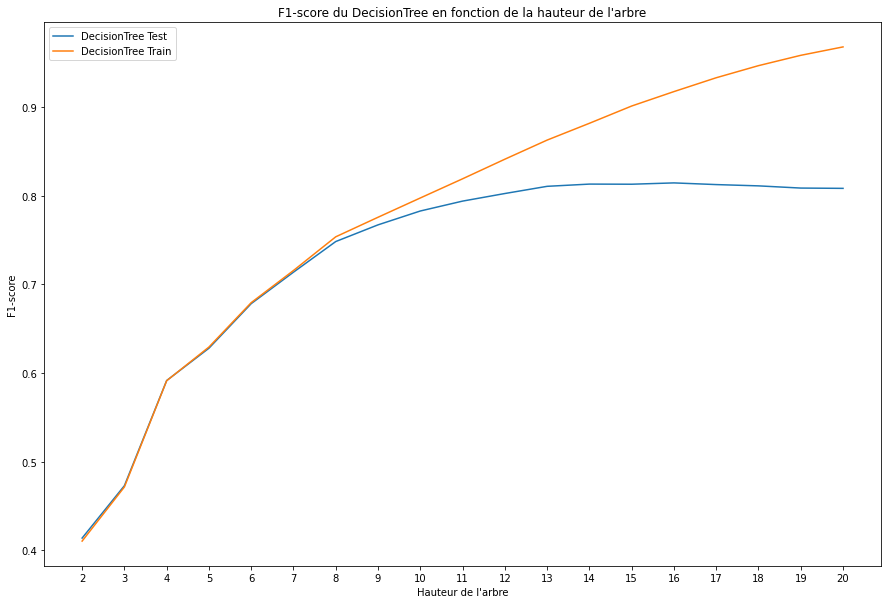

Une hauteur d'arbre entre 10 et 15 pour le DecisionTree


In [21]:
plt.rc('figure', figsize=(15, 10))
prec_dict ={'DecisionTree Test': prec_score_pred_DTC,
            'DecisionTree Train': prec_score_train_DTC,}


fig, ax = plt.subplots()


ax.set_title('F1-score du DecisionTree en fonction de la hauteur de l\'arbre')
ax.set_xlabel('Hauteur de l\'arbre')
ax.set_ylabel('F1-score')


for key in prec_dict.keys():
    
    plt.plot(param_range,prec_dict[key],label=key)


plt.xticks(np.arange(min(param_range), max(param_range)+1))
plt.legend()

plt.show()
print("Une hauteur d'arbre entre 10 et 15 pour le DecisionTree")


In [23]:
max_steps = 30
param_range = range(2,max_steps+1)

prec_score_pred_RFC =[]
prec_score_train_RFC = []

for i in param_range:
    # création du pipeline
    nutri_pipe = Pipeline([

        ##################### fonctions de preprocessing du pipeline ##################
        ('filler', SimpleImputer(missing_values=np.nan, strategy=fill_strat)), 
        ('standardizer', MinMaxScaler()),

        ####################### spécification du modèle #################################

        ('rfc', RandomForestClassifier(max_depth= i, random_state=0))])
    
    nutri_pipe.fit(X_train,y_train)
    
    y_pred=nutri_pipe.predict(X_test)
    y_comp=nutri_pipe.predict(X_train)
    # RandomForestClassifier
    # pas de déséquilibre de classe donc on peut utiliser sans weighted
    prec_score_pred_RFC.append(metrics.f1_score(y_pred, y_test, average='macro'))
    prec_score_train_RFC.append(metrics.f1_score(y_comp, y_train,average='macro'))

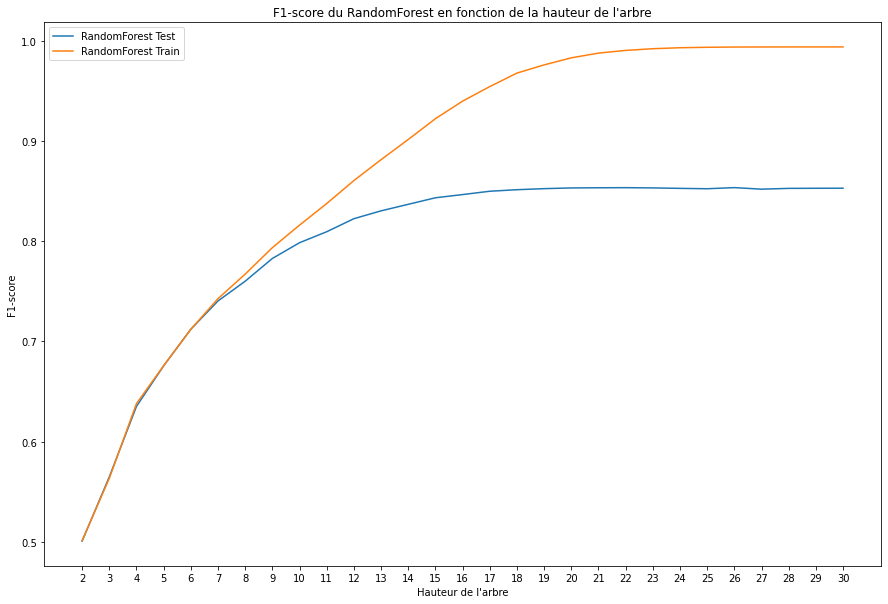

Une hauteur d'arbre entre 10 et 15 pour le RandomForest


In [24]:
plt.rc('figure', figsize=(15, 10))
prec_dict ={'RandomForest Test': prec_score_pred_RFC,
            'RandomForest Train': prec_score_train_RFC,}


fig, ax = plt.subplots()


ax.set_title('F1-score du RandomForest en fonction de la hauteur de l\'arbre')
ax.set_xlabel('Hauteur de l\'arbre')
ax.set_ylabel('F1-score')


for key in prec_dict.keys():
    
    plt.plot(param_range,prec_dict[key],label=key)


plt.xticks(np.arange(min(param_range), max(param_range)+1))
plt.legend()

plt.show()
print("Une hauteur d'arbre entre 10 et 15 pour le RandomForest")

In [26]:


max_steps = 20
param_range = range(2,max_steps+1)

prec_score_pred_KNC =[]
prec_score_train_KNC = []

for i in param_range:
    # création du pipeline
    nutri_pipe = Pipeline([

        ##################### fonctions de preprocessing du pipeline ##################
        ('filler', SimpleImputer(missing_values=np.nan, strategy=fill_strat)), 
        ('standardizer', StandardScaler()),

        ####################### spécification du modèle #################################
        # pas de random_state pour l'algo Kneighbors 
        ('knc', KNeighborsClassifier(n_neighbors= i))])
    
    nutri_pipe.fit(X_train,y_train)
    
    y_pred=nutri_pipe.predict(X_test)
    y_comp=nutri_pipe.predict(X_train)
    # RandomForestClassifier
    # pas de déséquilibre de classe donc on peut utiliser sans weighted
    prec_score_pred_KNC.append(metrics.f1_score(y_pred, y_test, average='macro'))
    prec_score_train_KNC.append(metrics.f1_score(y_comp, y_train,average='macro'))

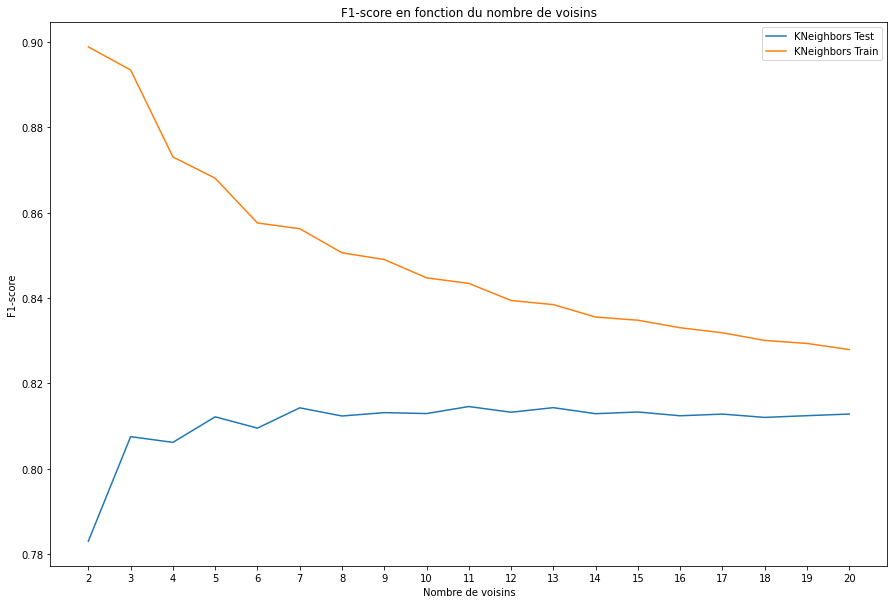

13 voisins plus proches pour le KNeighbors


In [27]:
plt.rc('figure', figsize=(15, 10))
prec_dict ={'KNeighbors Test': prec_score_pred_KNC,
            'KNeighbors Train': prec_score_train_KNC,}


fig, ax = plt.subplots()


ax.set_title('F1-score en fonction du nombre de voisins')
ax.set_xlabel('Nombre de voisins')
ax.set_ylabel('F1-score')


for key in prec_dict.keys():
    
    plt.plot(param_range,prec_dict[key],label=key)


plt.xticks(np.arange(min(param_range), max(param_range)+1))
plt.legend()

plt.show()
print("13 voisins plus proches pour le KNeighbors")

Le modèle de type KNeighbors offre de meilleurs scores:

    * Il est moins facile d'interprétation
    * Moins de contrôles sur des modèles complexes
    

In [28]:
nutri_pipe = Pipeline([

    ##################### fonctions de preprocessing du pipeline ##################
    ('filler', SimpleImputer(missing_values=np.nan, strategy='median')), 
    ('standardizer', MinMaxScaler()),

    ####################### spécification du modèle #################################

    ('rfc', RandomForestClassifier(max_depth= 13, random_state=0))])

# Entraînement du modèle
nutri_pipe.fit(X_train,y_train)


Pipeline(steps=[('filler', SimpleImputer(strategy='median')),
                ('standardizer', MinMaxScaler()),
                ('rfc', RandomForestClassifier(max_depth=13, random_state=0))])

Le RandomForest a été retenu:
    
    * Plus facile à comprendre
    * Meilleurs scores que le DecisionTree
    
Il faudrait tester l'ensemble des combinaisons d'hyper-paramètres, avec GridSearch

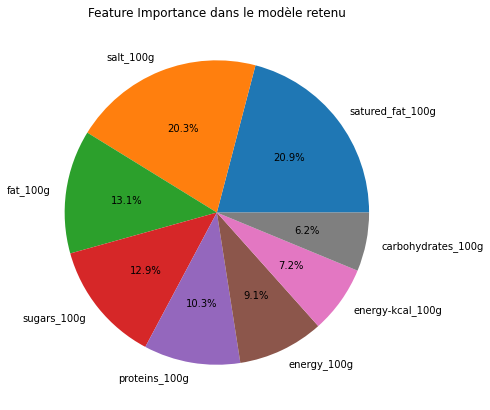

In [29]:
 def display_feat_imp_rfc(rfc):
    feat_imp = rfc.feature_importances_
    df_featimp = pd.DataFrame(feat_imp, columns={"Feature Importance"}, 
                              index=["energy-kcal_100g", "energy_100g", "fat_100g", "satured_fat_100g", 
                                     "carbohydrates_100g", "sugars_100g", "proteins_100g", "salt_100g"])                          
    df_featimp["Feature Name"] = X_train.columns
    df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
    df_featimp.plot.pie(y="Feature Importance", x="Feature Name",
                        title="Feature Importance dans le modèle retenu",legend=None, label="", autopct='%1.1f%%' ,figsize=(7,7))

    
display_feat_imp_rfc(nutri_pipe["rfc"])

## Démonstration !

# Conclusion

Notre modèle reste perfectible:
    
    * Erreurs de prédictions fréquentes
    * Le modèle est coûteux en ressources 

Pour l'améliorer nous pourrions mettre en place:

    * Un questionnaire de satisfaction
    * Alterner les modèles
    * Combiner les modèles

Le retour de l'utilisateur permettra de ré-ajuster le modèle